In [1]:
from pathlib import Path
import os
from clearml import Dataset
import pandas as pd

/Users/ghassen_benhadjlarbi/miniconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


# ClearML Dataset management

ClearML Data addresses 2 challenges:

- Accessibility: Making data easily accessible to remote workers
- Versioning: Linking data and experiments for better traceability

## Dataset Creation

ClearML Data can be used to create, manage, and version datasets. 
- Files can be stored in any storage locationby setting the "output_uri" parameter when creating a dataset. Values are None for default server or string for location (eg. "s3://...").
- "use_current_task" parameter controls whether a new task will be created for this dataset or use the current one.
- "parent_datasets" parameter is used to create child datasets that will inherit all the data from their parent datasets. Order matters.

For more info check the [Dataset.create sdk documentation](https://clear.ml/docs/latest/docs/references/sdk/dataset/#datasetcreate).

In [2]:
dataset = Dataset.create(dataset_name="toy dataset",
                  dataset_project="ClearmlStudySessions",
                  dataset_tags=["initial", "toy", "train"],
                  dataset_version="1.0.0",
                  description="Initial toy dataset for demo",
                  parent_datasets = None,
                  use_current_task=False,
                  output_uri=None)

ClearML results page: https://app.clear.ml/projects/24ccd12a63834b439d753c2aac93b43a/experiments/298a76582c004b66a6c85106bcb2d471/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/24ccd12a63834b439d753c2aac93b43a/experiments/298a76582c004b66a6c85106bcb2d471


## Adding files

Add files to dataset using the add_files and add_external_files methods.
- add_files: accepts path to folder or file, along with option "wildcard" and "recursive" argument to finetune selection, and other parameters. If a file is already in the dataset but has been modified, adding it again will only store the difference and bump the version number of the dataset.
- add_external_files: accepts "source_url" parameter which is string or list of string to remote files, adding just the link to them in the dataset, as well as a "dataset_path" parameter to set in what folder those external files will be put inside the dataset when downloaded, and a "wildcard" parameter

For more details, check the [Dataset documentation](https://clear.ml/docs/latest/docs/clearml_data/clearml_data_sdk)

In [3]:
dataset.add_files(path="./data/",
                  wildcard="*.jpg",)

Generating SHA2 hash for 3 files


100%|██████████| 3/3 [00:00<00:00, 1295.87it/s]

Hash generation completed


3

In [4]:
dataset.add_files(path="./data/train.csv")

1

In [5]:
dataset.add_external_files(source_url=[
    "https://test-videos.co.uk/vids/bigbuckbunny/mp4/h264/720/Big_Buck_Bunny_720_10s_1MB.mp4",
    "https://www2.cs.uic.edu/~i101/SoundFiles/PinkPanther30.wav"],
                           dataset_path="external/")

2

## Upload files

Using add_files or add_external_files only adds the tracking logic for the files. They are not uploaded yet.

To do so, use the upload method.

In [6]:
dataset.upload(show_progress=True,
               verbose=True)

Compressing /Users/ghassen_benhadjlarbi/Documents/stuff/clearml_tutorials/data/sample1.jpg
Compressing /Users/ghassen_benhadjlarbi/Documents/stuff/clearml_tutorials/data/sample2.jpg
Compressing /Users/ghassen_benhadjlarbi/Documents/stuff/clearml_tutorials/data/sample3.jpg
Compressing /Users/ghassen_benhadjlarbi/Documents/stuff/clearml_tutorials/data/train.csv
Uploading dataset changes (4 files compressed to 1.5 MiB) to https://files.clear.ml
File compression and upload completed: total size 1.5 MiB, 1 chunk(s) stored (average size 1.5 MiB)


## Finalize dataset

The dataset is still not considered as done, and we can still add, modify or remove files.

To mark a dataset as done or complete, we need to finalize it using the finalize method. This will mark the task as complete, and from there on, the dataset can no longer be modified.

In [7]:
dataset.finalize(verbose=True,
                 auto_upload=False #if you set it to true, you can skip the previous upload call
                 )

Updating statistics and genealogy


True

## Downloading and using a dataset

Use the get method to get a Dataset object. You can query by dataset id, dataset name, project name, ... 

If multiple datasets match the query, the most recent one is returned.


Then use the get_local_copy method to download an immutable cached version of the dataset, or use get_mutable_local_copy to download a mutable copy of the dataset to a specific folder to modify the dataset.

### Immutable dataset

In [8]:
toy_dataset = Dataset.get(dataset_project="ClearmlStudySessions",
                          dataset_name="toy dataset")

In [9]:
toy_dataset.id

'298a76582c004b66a6c85106bcb2d471'

In [10]:
path_to_immutable_dataset = toy_dataset.get_local_copy()

Once downloaded, the dataset is cached, and any subsequent downloads will instead use this cached version

In [11]:
print(path_to_immutable_dataset)

/Users/ghassen_benhadjlarbi/.clearml/cache/storage_manager/datasets/ds_298a76582c004b66a6c85106bcb2d471


In [12]:
os.listdir(path_to_immutable_dataset)
# Notice that the external links were download into the "external" folder as we specified when we added the links

['sample1.jpg', 'sample3.jpg', 'sample2.jpg', 'train.csv', 'external']

In [13]:
os.listdir(path_to_immutable_dataset + "/external")

['PinkPanther30.wav', 'Big_Buck_Bunny_720_10s_1MB.mp4']

### Mutable dataset

In [14]:
path_to_mutable_dataset = Path("./mutable/")

In [16]:
toy_dataset.get_mutable_local_copy(target_folder=str(path_to_mutable_dataset))

'/Users/ghassen_benhadjlarbi/Documents/stuff/clearml_tutorials/mutable'

## Remove files

Remove files from the dataset using the remove_files method
- remove_files: accepts a "dataset_path" argument which can be a wildcard to remove matching files from the dataset. The path must be relative to the dataset base folder.

If we try to remove a file from a finalized dataset, an error will be raised.

In [17]:
dataset.remove_files(dataset_path="sample3.jpg")

Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=completed)> (task=298a76582c004b66a6c85106bcb2d471, artifacts=[{'key': 'data', 'type': 'custom', 'uri': 'https://files.clear.ml/ClearmlStudySessions/.datasets/toy%20dataset/toy%20dataset.298a76582c004b66a6c85106bcb2d471/artifacts/data/dataset.298a76582c004b66a6c85106bcb2d471.0lge4yo_.zip', 'content_size': 1575112, 'hash': 'ea05fc751d073b505b38c395875c105f542586897f48decfac7d360425271aac', 'timestamp': 1681963582, 'type_data': {'preview': 'sample1.jpg - 703.37 KB\ntrain.csv - 22.01 KB\nsample3.jpg - 170.55 KB\nsample2.jpg - 337.89 KB\n', 'content_type': 'application/zip'}}, {'key': 'state', 'type': 'dict', 'uri': 'https://files.clear.ml/ClearmlStudySessions/.datasets/toy%20dataset/toy%20dataset.298a76582c004b66a6c85106bcb2d471/artifacts/state/state.json', 'content_size': 1682, 'hash': '50507b35d9bd29b07b09771542ce8ebabf0a09f5f0f5287469cc42f941e655e7', 'timestamp': 1681963732, 'type

1

In [18]:
updated_dataset = Dataset.create(dataset_name="toy dataset",
                  dataset_project="ClearmlStudySessions",
                  parent_datasets=[toy_dataset],
                  output_uri=None)

ClearML results page: https://app.clear.ml/projects/24ccd12a63834b439d753c2aac93b43a/experiments/e5b1667285b84f8d9266dff57f782ce0/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/24ccd12a63834b439d753c2aac93b43a/experiments/e5b1667285b84f8d9266dff57f782ce0


In [19]:
updated_dataset.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'sample1.jpg',
 'sample2.jpg',
 'sample3.jpg',
 'train.csv']

In [20]:
toy_dataset.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'sample1.jpg',
 'sample2.jpg',
 'sample3.jpg',
 'train.csv']

In [21]:
updated_dataset.remove_files(dataset_path="*.jpg", recursive=True, verbose=True)

Remove sample2.jpg
Remove sample3.jpg
Remove sample1.jpg


3

In [22]:
updated_dataset.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'train.csv']

In [23]:
updated_dataset.finalize(verbose=True, auto_upload=True)

Updating statistics and genealogy


True

## Modify files

To modify a file, you just need to modify it and add it again to the dataset. This will create a new dataset version and only the diff between the 2 versions will be uploaded.

In [24]:
updated_dataset2 = Dataset.create(dataset_name="toy dataset",
                  dataset_project="ClearmlStudySessions",
                  parent_datasets=[updated_dataset],
                  output_uri=None)

ClearML results page: https://app.clear.ml/projects/24ccd12a63834b439d753c2aac93b43a/experiments/c31a00a2b82d4fdbb186686e9c3c7fb2/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/24ccd12a63834b439d753c2aac93b43a/experiments/c31a00a2b82d4fdbb186686e9c3c7fb2


In [25]:
updated_dataset.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'train.csv']

In [26]:
updated_dataset2.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'train.csv']

In [27]:
path_to_mutable_dataset2 = Path("./mutable2/")

In [28]:
updated_dataset.get_mutable_local_copy(path_to_mutable_dataset2)

'/Users/ghassen_benhadjlarbi/Documents/stuff/clearml_tutorials/mutable2'

In [29]:
df = pd.read_csv(path_to_mutable_dataset2/"train.csv")

In [30]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [31]:
df.head().to_csv(path_to_mutable_dataset2/"train.csv", index=False)

In [32]:
updated_dataset2.add_files(path_to_mutable_dataset2)

Generating SHA2 hash for 3 files


100%|██████████| 3/3 [00:00<00:00, 1410.64it/s]

Hash generation completed


0

In [33]:
updated_dataset2.finalize(verbose=True, auto_upload=True)

Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (1 files compressed to 438 B) to https://files.clear.ml
File compression and upload completed: total size 438 B, 1 chunk(s) stored (average size 438 B)
Updating statistics and genealogy


True

## Multiple parents

A dataset can have multiple parents.

It will inherit all the data from all their parents, but the order of the parents matter!

If more than one parent dataset contains a same named file in the same location, the later datasets will overwrite it with their content.

### Create a new dataset which contains some files, along with train.csv

In [34]:
config_dataset = Dataset.create(dataset_name="config dataset",
                  dataset_project="ClearmlStudySessions",
                  dataset_tags=["initial", "config"],
                  dataset_version="1.0.0",
                  description="Initial config dataset for demo",
                  parent_datasets = None,
                  use_current_task=False,
                  output_uri=None)

ClearML results page: https://app.clear.ml/projects/5fa1394fada9490485f2245ced21d036/experiments/1a0b04fe6b1e450690ae293adcf21c78/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/5fa1394fada9490485f2245ced21d036/experiments/1a0b04fe6b1e450690ae293adcf21c78


In [35]:
config_dataset.add_files("./data/config.yaml")
config_dataset.add_files("./data/sample_json.json")
config_dataset.add_files("./data/train.csv")

1

In [36]:
config_dataset.list_files()

['config.yaml', 'sample_json.json', 'train.csv']

In [37]:
config_dataset.finalize(verbose=True, auto_upload=True)

Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (3 files compressed to 21.97 KiB) to https://files.clear.ml
File compression and upload completed: total size 21.97 KiB, 1 chunk(s) stored (average size 21.97 KiB)
Updating statistics and genealogy


True

### Create a new combined dataset between config_dataset and updated_dataset2

In [38]:
combined_dataset = Dataset.create(dataset_name="combined dataset",
                  dataset_project="ClearmlStudySessions",
                  dataset_tags=["config", "toy", "combined"],
                  dataset_version="1.0",
                  description="Combined dataset of config dataset and toy dataset",
                  parent_datasets = [config_dataset.id, updated_dataset2.id]
    
)

ClearML results page: https://app.clear.ml/projects/3051026447b444d4b4720229444fb376/experiments/9b0f5596df4e4c4293f8cdbb65b3217d/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/3051026447b444d4b4720229444fb376/experiments/9b0f5596df4e4c4293f8cdbb65b3217d


In [39]:
config_dataset.list_files()

['config.yaml', 'sample_json.json', 'train.csv']

In [40]:
updated_dataset2.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'train.csv']

In [41]:
combined_dataset.list_files()

['config.yaml',
 'external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'sample_json.json',
 'train.csv']

In [42]:
combined_dataset.finalize(verbose=True, auto_upload=True)

Updating statistics and genealogy


True

In [43]:
path_to_combined_dataset = Path(combined_dataset.get_local_copy())

In [44]:
combined_df = pd.read_csv(path_to_combined_dataset / "train.csv")

In [45]:
combined_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Because we set updated_dataset2 as the 2nd parent, the contents of "train.csv" of updated_dataset2 overwrote the contents of "train.csv" of config_dataset

## Squash datasets

If you have many versions of a dataset, it may be useful to squash it and make a new, independant version with all the changes introduced.

My understanding is that if you want the latest version of a dataset, ClearML will download all the previous versions and apply the changes one by one.

If the DAG is deep, this becomes inefficient both for storage and execution speed. In those cases, squashing would be better.

If you give a single dataset_id, it will squash from the root of that version up to the version.
If you give multiple dataset_id, it will squash only the specified versions diff (not really sure what this means to be honest).

In [46]:
squashed_dataset = Dataset.squash(dataset_name="Squashed toy dataset",
                                  dataset_ids=[updated_dataset2.id])

ClearML results page: https://app.clear.ml/projects/8745bee5f90d4b96a898217e4b1c3f90/experiments/c3063db877ed44c0a9788c0435655fee/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/8745bee5f90d4b96a898217e4b1c3f90/experiments/c3063db877ed44c0a9788c0435655fee
Generating SHA2 hash for 3 files


100%|██████████| 3/3 [00:00<00:00, 1302.71it/s]

Hash generation completed


Uploading dataset changes (3 files compressed to 1.97 MiB) to https://files.clear.ml
File compression and upload completed: total size 1.97 MiB, 1 chunk(s) stored (average size 1.97 MiB)


In [47]:
squashed_dataset.list_files()

['external/Big_Buck_Bunny_720_10s_1MB.mp4',
 'external/PinkPanther30.wav',
 'train.csv']

## Logging in datasets

You can log in the same way as in tasks using the logger from the dataset.

Use get_logger() method to get the logger, and then log as usual.

In [77]:
logging_dataset = Dataset.create(dataset_name="logging",
                                 dataset_project="ClearmlStudySessions")

ClearML results page: https://app.clear.ml/projects/b16cf8a180e44b06b96bccc060f11611/experiments/c5479f10892a477f8441915b5a9915b8/output/log
ClearML dataset page: https://app.clear.ml/datasets/simple/b16cf8a180e44b06b96bccc060f11611/experiments/c5479f10892a477f8441915b5a9915b8


In [78]:
logging_dataset.add_files("./data/")

Generating SHA2 hash for 6 files


100%|██████████| 6/6 [00:00<00:00, 6178.69it/s]

Hash generation completed


6

In [79]:
logger = logging_dataset.get_logger()

In [80]:
import matplotlib.pyplot as plt
import numpy as np

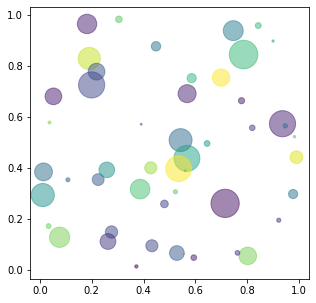

In [81]:
fig, _ = plt.subplots(figsize=(5, 5))
N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = (30 * np.random.rand(N))**2  # 0 to 15 point radii
plt.scatter(x, y, s=area, c=colors, alpha=0.5)

In [82]:
logger.report_matplotlib_figure(title="Manual matplotlib report", 
                                series="Just a plot", 
                                iteration=0,
                                figure=fig)

In [83]:
logger.report_table(title="Manual csv report", 
                                series="Just a csv", 
                                iteration=0,
                                csv="./mutable2/train.csv")

In [84]:
logger.report_single_value("Train", 0.8)
logger.report_single_value("Val", 0.1)
logger.report_single_value("Test", 0.1)

In [88]:
logging_dataset.set_metadata({
                        "train" : 160,
                        "val" : 20,
                        "test" : 20
                    },
                     metadata_name="Splits distribution")

Displaying metadata in the UI is only supported for pandas Dataframes for now. Skipping!


In [89]:
logging_dataset.finalize(verbose=True, auto_upload=True)

Pending uploads, starting dataset upload to https://files.clear.ml
Uploading dataset changes (6 files compressed to 1.5 MiB) to https://files.clear.ml
File compression and upload completed: total size 1.5 MiB, 1 chunk(s) stored (average size 1.5 MiB)
Updating statistics and genealogy


True

# CLI

ClearML dataset functionality is also available as a CLI tool.

For more info, refer to the [CLI documentation](https://clear.ml/docs/latest/docs/clearml_data/clearml_data_cli)